<a href="https://colab.research.google.com/github/rajy4683/EVAP2/blob/master/END_NoCoDeR_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Sun Mar 21 17:56:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch
import pandas as pd
import numpy as np
import fileinput
import re
import itertools
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
#import seaborn as sns
import dateutil.parser
import datetime
#from ipyfilechooser import FileChooser
import numpy as np
import os
import gzip
import dateutil.parser
from datetime import datetime
import sys
import glob
import matplotlib.dates as mdates
from datetime import timedelta
import ipywidgets as widgets
from IPython.display import display
import torch
import json
import random
import spacy
from pprint import pprint
import six
import sys, token, tokenize
import ast
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import random
import math
import time
from torch.utils.data.distributed import DistributedSampler
#from tensorboardX import SummaryWriter
from tqdm import tqdm, trange
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install transformers
!pip install rouge-score

     |████████████████████████████████| 2.0MB 5.3MB/s 
     |████████████████████████████████| 890kB 17.7MB/s 
     |████████████████████████████████| 3.2MB 22.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=529020aaba6a6e2d0b6582297aa1c56fa00a9371ea22b15d4bda5c39e749e3a9
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [6]:
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import tokenize
from rouge_score import rouge_scorer


In [7]:
# %%bash
# python -m spacy download en
# python -m spacy download de

In [8]:
# !wget https://s3.amazonaws.com/code-search-net/CodeSearchNet/v2/python.zip
# !wget -O gpt2_bpe_encoder.json https://dl.fbaipublicfiles.com/fairseq/gpt2_bpe/encoder.json

# !unzip /content/python.zip
# !cp /content/python/final/jsonl/train/python_train_0.jsonl.gz .
# !gzip -d /content/python_train_0.jsonl.gz

!cp /content/drive/MyDrive/EVA4/END_Capstone/english_python_data.txt .
!cp /content/drive/MyDrive/EVA4/END_Capstone/english_python_cleaned.txt .
!cp /content/drive/MyDrive/EVA4/END_Capstone/end_capstone.csv .

In [9]:
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel
from transformers import AutoTokenizer, AutoModel


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
auto_tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
# spacy_en = spacy.load('en')
# def tokenize_en(text):
#     """
#     Tokenizes English text from a string into a list of strings
#     """
#     return [tok.text for tok in spacy_en.tokenizer(text)]
#model = RobertaModel.from_pretrained("microsoft/codebert-base")
#model.to(device)

In [10]:
"""
    Removes docstrings and comments
"""
def remove_docstrings_comments(src_string, doc_string=None, debug=False):
    mod = []

    prev_toktype = token.INDENT
    first_line = None
    last_lineno = -1
    last_col = 0
    try:
        #tokgen = tokenize.generate_tokens(source.readline)
        tokgen = tokenize.generate_tokens(six.StringIO(src_string.rstrip()).readline)
        for toktype, ttext, (slineno, scol), (elineno, ecol), ltext in tokgen:
            if 0:   # Change to if 1 to see the tokens fly by.
                print("%10s %-14s %-20r %r" % (
                    tokenize.tok_name.get(toktype, toktype),
                    "%d.%d-%d.%d" % (slineno, scol, elineno, ecol),
                    ttext, ltext
                    ))
            if slineno > last_lineno:
                last_col = 0
            if scol > last_col:
                mod.append(" " * (scol - last_col))
            if toktype == token.STRING and prev_toktype == token.INDENT:
                # Docstring
                mod.append("#--")
            elif toktype == tokenize.COMMENT:
                # Comment
                mod.append("##")
            else:
                mod.append(ttext)
            prev_toktype = toktype
            last_col = ecol
            last_lineno = elineno
        return "".join(mod)
    except:
        print(doc_string)
        print(src_string )
        print(sys.exc_info())

### Create datasets and dataloaders

In [11]:
nl_to_pl_df = pd.read_csv('/content/end_capstone.csv')

In [12]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [13]:
print(nl_to_pl_df['code_len'].max(),nl_to_pl_df['code_len'].min())
print(nl_to_pl_df['docstring_len'].max(),nl_to_pl_df['docstring_len'].min())
nl_to_pl_df[nl_to_pl_df['code_len'] ==0]
nl_to_pl_df[(nl_to_pl_df['code_len'] < 256) & (nl_to_pl_df['code_len'] < 512)] 

2443 11
313 16


,docstring,code,docstring_len,code_len,cleaned_code,cleaned_code_len
0,# write a python program to add two numbers\n,num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\npri...,44,63,num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\npri...,60
1,# write a python function to add two user prov...,"def add_two_numbers(num1, num2):\n sum = nu...",78,72,"def add_two_numbers(num1, num2):\n sum = nu...",69
2,# write a program to find and print the larges...,\nnum1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >=...,68,202,\nnum1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >=...,199
3,# write a program to find and print the smalle...,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <= n...,69,206,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <= n...,203
4,# Write a python function to merge two given l...,"def merge_lists(l1, l2):\n return l1 + l2\n...",60,46,"def merge_lists(l1, l2):\n return l1 + l2",43
...,...,...,...,...,...,...
4356,# Write a python program for selection sort\n,for i in range(len(A)):\n min_idx = i\n ...,44,165,for i in range(len(A)):\n min_idx = i\n ...,163
4357,# Write a python program for implementation of...,def bubbleSort(arr):\n n = len(arr)\n fo...,59,237,def bubbleSort(arr):\n n = len(arr)\n fo...,235
4358,# Write a python program to check if a number ...,"n=int(input(""Enter any number: ""))\na=list(map...",70,212,"n=int(input(""Enter any number: ""))\na=list(map...",210
4361,# Write a python to find LCM of two numbers\n,"a=int(input(""Enter the first number:""))\nb=int...",44,226,"a=int(input(""Enter the first number:""))\nb=int...",224


In [15]:
nl_to_pl_df['code_len'].quantile([0.5, 0.75, 0.85, 0.9, 0.95])

0.50    132.0
0.75    216.0
0.85    271.0
0.90    319.0
0.95    430.0
Name: code_len, dtype: float64

In [14]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    # if n_gpu > 0:
    #     torch.cuda.manual_seed_all(seed)
set_seed(0x1112233)

In [15]:
!cp -rf /content/drive/MyDrive/EVA4/END_Capstone/cubert .
!pip install -r /content/cubert/requirements.txt
sys.path.append("/content/cubert/")

     |████████████████████████████████| 71kB 3.5MB/s 
     |████████████████████████████████| 92kB 4.6MB/s 
     |████████████████████████████████| 1.5MB 25.7MB/s 
     |████████████████████████████████| 412.3MB 43kB/s 
     |████████████████████████████████| 368kB 42.9MB/s 
     |████████████████████████████████| 983kB 40.5MB/s 
     |████████████████████████████████| 655kB 13.9MB/s 
     |████████████████████████████████| 706kB 37.3MB/s 
     |████████████████████████████████| 81kB 8.8MB/s 
     |████████████████████████████████| 194kB 26.0MB/s 
     |████████████████████████████████| 5.6MB 39.8MB/s 
     |████████████████████████████████| 368kB 34.5MB/s 
     |████████████████████████████████| 358kB 37.4MB/s 
     |████████████████████████████████| 3.8MB 31.0MB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
     |████████████████████████████████| 512kB 42.6MB/s 
     |████████████████████████████████| 256kB 41.2MB/s 
     |████████████████████████████████| 163kB 44.0MB/s 


In [16]:
"""A Python tokenizer subclass of CuBertTokenizer."""
import keyword
import re
import tokenize
import typing
from typing import Any
from typing import List
from typing import Sequence
from typing import Tuple
from absl import logging
from cubert import cubert_tokenizer
from cubert import unified_tokenizer


class PythonTokenizer2(cubert_tokenizer.CuBertTokenizer):
  """Tokenizer that extracts Python's lexical elements preserving strings."""
  _TOKEN_TYPE_MAP = {
      tokenize.COMMENT: unified_tokenizer.TokenKind.COMMENT,
      tokenize.DEDENT: unified_tokenizer.TokenKind.KEYWORD,
      tokenize.ENDMARKER: unified_tokenizer.TokenKind.EOS,
      tokenize.ERRORTOKEN: unified_tokenizer.TokenKind.ERROR,
      tokenize.INDENT: unified_tokenizer.TokenKind.KEYWORD,
      tokenize.NEWLINE: unified_tokenizer.TokenKind.NEWLINE,
      tokenize.NL: unified_tokenizer.TokenKind.PUNCTUATION,
      tokenize.NUMBER: unified_tokenizer.TokenKind.NUMBER,
      tokenize.OP: unified_tokenizer.TokenKind.PUNCTUATION,
      tokenize.STRING: unified_tokenizer.TokenKind.STRING,
  }
  _REVERSE_TOKEN_MAP = {
      cubert_tokenizer.token_from_token_type(tokenize.INDENT):
          tokenize.INDENT,
      cubert_tokenizer.token_from_token_type(tokenize.DEDENT):
          tokenize.DEDENT,
      unified_tokenizer.quote_special(unified_tokenizer.TokenKind.EOS.name):
          tokenize.ENDMARKER,
      unified_tokenizer.quote_special(unified_tokenizer.TokenKind.ERROR.name):
          tokenize.ERRORTOKEN,
      unified_tokenizer.quote_special(unified_tokenizer.TokenKind.NEWLINE.name):
          tokenize.NEWLINE,
      cubert_tokenizer.token_from_token_type(tokenize.NL):
          tokenize.NL,
  }
  # Adding the end-of-string anchor \Z below, since re.fullmatch wasn't
  # available in Python2.
  _NUMBERS = re.compile('(' + tokenize.Number + r')\Z')  # pytype: disable=module-attr
  _SINGLE_STRINGS = re.compile('(' + tokenize.String + r')\Z')  # pytype: disable=module-attr
  _TRIPLE_STRING_BEGINNINGS = re.compile(tokenize.Triple)  # pytype: disable=module-attr
  _COMMENTS = re.compile('(' + tokenize.Comment + r')\Z')  # pytype: disable=module-attr

  _EXACT_TOKEN_TYPES = tokenize.EXACT_TOKEN_TYPES.keys()  # pytype: disable=module-attr

  # Token types that CubertTokenizer will tokenize by their type and not
  # content.
  _TOKEN_TYPES_TO_TOKENIZE_BY_TYPE = [
      tokenize.NEWLINE, tokenize.DEDENT, tokenize.NL
  ]

  def tokenize_and_abstract(
      self,
      source_code):
    """Produces a language-agnostic tokenization of the input code."""
    agnostic_tokens: List[unified_tokenizer.AbstractToken] = []

    try:
      token_tuples = unified_tokenizer.code_to_tokens(source_code)
    except (tokenize.TokenError, IndentationError) as e:
      logging.warning('The tokenizer raised exception `%s` while parsing %s', e,
                      source_code)

      # We don't try to do recovery from errors quite yet. Emit just an
      # error and end-of-sequence and return.
      agnostic_tokens.append(
          unified_tokenizer.AbstractToken(
              unified_tokenizer.quote_special(
                  unified_tokenizer.TokenKind.ERROR.name),
              unified_tokenizer.TokenKind.ERROR,
              unified_tokenizer.TokenMetadata(
                  start=unified_tokenizer.Position(
                      line=0, column=0),
                  end=unified_tokenizer.Position(
                      line=0, column=0))))
      agnostic_tokens.append(
          unified_tokenizer.AbstractToken(
              unified_tokenizer.quote_special(
                  unified_tokenizer.TokenKind.EOS.name),
              unified_tokenizer.TokenKind.EOS,
              unified_tokenizer.TokenMetadata(
                  start=unified_tokenizer.Position(
                      line=0, column=0),
                  end=unified_tokenizer.Position(
                      line=0, column=0))))
      return agnostic_tokens

    for token_tuple in token_tuples:
      spelling = token_tuple.string
      kind = token_tuple.type

      # We'll adjust the spelling of some tokens, e.g., those that we
      # tokenize by their type rather than their original spelling. Indentation
      # and dedentation tokens are like that.
      adjusted_spelling = spelling
      token_kind = unified_tokenizer.TokenKind.NONE
      if kind == tokenize.NAME:
        # Disambiguate identifiers from keywords.
        if keyword.iskeyword(spelling):
          token_kind = unified_tokenizer.TokenKind.KEYWORD
        else:
          token_kind = unified_tokenizer.TokenKind.IDENTIFIER
      else:
        if kind in PythonTokenizer2._TOKEN_TYPES_TO_TOKENIZE_BY_TYPE:
          # Replace spelling with type.
          adjusted_spelling = cubert_tokenizer.token_from_token_type(kind)
        elif kind is tokenize.INDENT:
          # For INDENT, in particular, we also record the actual spelling too.
          adjusted_spelling = '{indent}{spelling}'.format(
              indent=cubert_tokenizer.token_from_token_type(kind),
              spelling=spelling)
          #print(adjusted_spelling)
        elif kind == tokenize.ENDMARKER:
          adjusted_spelling = unified_tokenizer.quote_special(
              unified_tokenizer.TokenKind.EOS.name)

        # Map everything according to table.
        try:
          token_kind = PythonTokenizer2._TOKEN_TYPE_MAP[kind]
        except KeyError as ke:
          # It's possible we're here because of async/await. Those kept being
          # turned into keywords and then removed from keywords, so we can't
          # rely on knowing which they are. We'll check by spelling.
          # See: https://bugs.python.org/issue30406
          # and https://bugs.python.org/issue33260
          # and https://bugs.python.org/issue35975
          if spelling in ('async', 'await'):
            token_kind = unified_tokenizer.TokenKind.KEYWORD
          else:
            raise ValueError('While trying to turn Python token %r into an '
                             'agnostic one, raised %r.' %
                             ((spelling, kind), ke))

      start_line, start_column = token_tuple.start
      end_line, end_column = token_tuple.end
      # Unlike other languages, NEWLINE tokens are reported as ending on the
      # same line as where they started. We adjust that here, to stick to the
      # same convention as other tokenizers.
      if ((token_kind == unified_tokenizer.TokenKind.NEWLINE) or
          (kind == tokenize.NL)):
        end_line = start_line + 1
        end_column = 0

      agnostic_tokens.append(
          unified_tokenizer.AbstractToken(
              spelling=adjusted_spelling, kind=token_kind,
              metadata=unified_tokenizer.TokenMetadata(
                  # Python's tokenizer counts lines starting from 1, so we
                  # have to offset what we read from the `TokenInfo` tuple.
                  start=unified_tokenizer.Position(
                      line=start_line - 1, column=start_column),
                  end=unified_tokenizer.Position(
                      line=end_line - 1, column=end_column))))
    #print(agnostic_tokens)
    return agnostic_tokens

  def untokenize_abstract(self, whole_tokens):
    # Reconstruct Python tokenizer tuples, so that Python's untokenize can be
    # invoked.
    token_tuples: List[Tuple[int, str]] = []

    for whole_token in whole_tokens:
      if whole_token in PythonTokenizer2._EXACT_TOKEN_TYPES:
        token_tuples.append((tokenize.OP, whole_token))
      elif cubert_tokenizer.token_from_token_type(
          tokenize.INDENT) in whole_token:
        # We baked the type and spelling into one token. Break them up.
        spelling = whole_token.replace(
            cubert_tokenizer.token_from_token_type(tokenize.INDENT), '')
        token_tuples.append((tokenize.INDENT, spelling))
      elif whole_token in PythonTokenizer2._REVERSE_TOKEN_MAP:
        python_kind = PythonTokenizer2._REVERSE_TOKEN_MAP[whole_token]
        if python_kind in (tokenize.DEDENT, tokenize.ENDMARKER,
                           tokenize.ERRORTOKEN):
          spelling = ''
        else:  # python_kind in (tokenize.NEWLINE, tokenize.NL)
          spelling = '\n'
        token_tuples.append((python_kind, spelling))
      elif keyword.iskeyword(whole_token):
        token_tuples.append((tokenize.NAME, whole_token))
      elif PythonTokenizer2._NUMBERS.match(whole_token):
        token_tuples.append((tokenize.NUMBER, whole_token))
      elif PythonTokenizer2._SINGLE_STRINGS.match(whole_token):
        token_tuples.append((tokenize.STRING, whole_token))
      elif PythonTokenizer2._TRIPLE_STRING_BEGINNINGS.match(whole_token):
        token_tuples.append((tokenize.STRING, whole_token))
      elif PythonTokenizer2._COMMENTS.match(whole_token):
        token_tuples.append((tokenize.COMMENT, whole_token))
      else:
        # Everything else we map back to NAME.
        token_tuples.append((tokenize.NAME, whole_token))

    reconstructed = tokenize.untokenize(typing.cast(Any, token_tuples))
    return reconstructed



In [17]:
def get_lang_specific_tokens(init_tokenizer, code_snip):
    #tokens_complete = init_tokenizer.tokenize(source_code=code_snip)
    tokens = init_tokenizer.tokenize_and_abstract(source_code=code_snip )
    conditioned = init_tokenizer.condition_full_tokens(tokens)
    agnostic_token_lists = unified_tokenizer._agnostic_tokens_to_lists_of_token_lists(conditioned)
    with_identifiers_heuristically_split = unified_tokenizer._subtokenize_identifiers_heuristically(
        agnostic_token_lists)
    with_string_tokens_heuristically_split = unified_tokenizer._subtokenize_strings_heuristically(
        with_identifiers_heuristically_split)
    shortened_subtokens = unified_tokenizer._shorten_subtokens(with_string_tokens_heuristically_split, 20)
    sanitization_mapping = init_tokenizer.get_mappings()
    subtoken_lists = unified_tokenizer.sanitize_subtoken_lists(shortened_subtokens,
                                            sanitization_mapping,
                                            unified_tokenizer.SENTINEL)
    #flat_toks =unified_tokenizer.flatten_subtoken_lists(subtoken_lists)
    test_spellings = []
    test_tok_types = []
    for t in subtoken_lists:
        #if(len(t.spelling) == 1):
        #print(len(t.spellings))
        test_spellings.extend(t.spellings)
        match=False
        for cubert_token in set(init_tokenizer._REVERSE_TOKEN_MAP.keys()):
            #print("Checking for:",cubert_token)
            if cubert_token in t.spellings[0]:
                #print(t.spellings)
                selected_token = tokenize.tok_name[init_tokenizer._REVERSE_TOKEN_MAP[cubert_token]]
                test_tok_types.extend([selected_token]*len(t.spellings))
                match=True          
        if match == False:
            test_tok_types.extend([t.kind.name]*len(t.spellings))
    return test_spellings, test_tok_types



In [18]:
class NewVectorizer():
    def __init__(self, code_piece, tok_type_counter):
        self.code_piece = code_piece
        self.tok_type_counter = tok_type_counter
        self.code_word2idx = {'<s>':0,'</s>':1,'<pad>':2, '<unk>':3}
        self.code_idx2word = {v:k for k,v in self.code_word2idx.items()}
        self.toktype_word2idx = {'<s>':0,'</s>':1,'<pad>':2, '<unk>':3}
        self.toktype_idx2word = {v:k for k,v in self.toktype_word2idx.items()}
        self.max_tok_length = len(self.toktype_word2idx)
        self.max_code_length = len(self.code_word2idx)
        self.UNK_FOR_TOKEN_TYPE = '<unk>'
        self.UNK_FOR_CODEPIECE = '<unk>'
        self.ID_UNK_TOKEN_TYPE = self.toktype_word2idx[self.UNK_FOR_TOKEN_TYPE]
        self.ID_UNK_CODEPIECE = self.code_word2idx[self.UNK_FOR_CODEPIECE]

        self.PAD_FOR_CODEPIECE = '<pad>'
        self.PAD_FOR_TOKEN_TYPE = '<pad>'
        self.ID_PAD_FOR_CODEPIECE = self.code_word2idx['<pad>']
        self.ID_PAD_FOR_TOKEN_TYPE = self.toktype_word2idx['<pad>']
        
        self.SOS_FOR_CODEPIECE = '<s>'
        self.SOS_FOR_TOKEN_TYPE = '<s>'
        self.ID_SOS_FOR_CODEPIECE = self.code_word2idx['<s>']
        self.ID_SOS_FOR_TOKEN_TYPE = self.toktype_word2idx['<s>']

        self.EOS_FOR_CODEPIECE = '</s>'
        self.EOS_FOR_TOKEN_TYPE = '</s>'
        self.ID_EOS_FOR_CODEPIECE = self.code_word2idx['</s>']
        self.ID_EOS_FOR_TOKEN_TYPE = self.toktype_word2idx['</s>']
        self.build_vocab()

    def build_vocab(self):
        idx=len(self.code_word2idx.keys())
        for k in self.code_piece.keys():
            self.code_word2idx[k]=idx
            self.code_idx2word[idx]=k
            idx += 1
        
        idx=len(self.toktype_word2idx.keys())
        for k in self.tok_type_counter.keys():
            self.toktype_word2idx[k]=idx
            self.toktype_idx2word[idx]=k
            idx += 1

        self.max_tok_length = len(self.toktype_word2idx.keys())
        self.max_code_length = len(self.code_word2idx.keys())
    ### Returns the code piece for a given ID
    def convert_id_to_codepiece(self, id_for_code):
        if(id_for_code not in list(self.code_idx2word.keys())):
            return self.UNK_FOR_CODEPIECE
        return self.code_idx2word[id_for_code]
    ### Returns the ID for a given code piece
    def convert_codepiece_to_id(self, code_piece):
        if(code_piece not in list(self.code_word2idx.keys())):
            return self.ID_UNK_CODEPIECE
        return self.code_word2idx[code_piece]
    ### Returns the TOKEN ID for a given TOKEN type
    def convert_toktype_to_id(self, tok_piece):
        if(tok_piece not in list(self.toktype_word2idx.keys())):
            print("No match for",tok_piece)
            return self.ID_UNK_TOKEN_TYPE
        return self.toktype_word2idx[tok_piece]
    ### Returns the TOKEN type for a given TOKEN ID
    def convert_id_to_toktype(self, id_for_toktype):
        if(id_for_toktype not in list(self.toktype_idx2word.keys())):
            return self.UNK_FOR_TOKEN_TYPE
        return self.toktype_idx2word[id_for_toktype]

In [19]:
sys.path.append("/content/cubert")

In [20]:
import cubert
from absl import app
from absl import flags
from tensor2tensor.data_generators import text_encoder
import enum
import cubert_tokenizer
from cubert import code_to_subtokenized_sentences
#from cubert import tokenizer_registry
from cubert import python_tokenizer
import python_tokenizer
from tensor2tensor.data_generators import text_encoder_build_subword
from collections import Counter, defaultdict

@enum.unique
class TokenizerEnum(enum.Enum):
  """Enum for Tokenizers."""
  #PYTHON = python_tokenizer.PythonTokenizer
  PYTHON = PythonTokenizer2

In [21]:
#### Generate and create the Vectorizer instance
word_counter=Counter()
init_tokenizer=PythonTokenizer2()
tok_type_counter = Counter()
for code_snip in nl_to_pl_df['cleaned_code']:
    toks, tok_types = get_lang_specific_tokens(init_tokenizer, code_snip)
    word_counter.update(Counter(toks))
    tok_type_counter.update(Counter(tok_types))

In [22]:
code_tok_vectorizer = NewVectorizer(word_counter, tok_type_counter)
print(f"Size of Code Vocab:{code_tok_vectorizer.max_code_length} ")
print(f"Size of Token Vocab:{code_tok_vectorizer.max_tok_length} ")

Size of Code Vocab:5813 
Size of Token Vocab:16 


### Vectorizer and Dataset generator

In [23]:
tok_ids_list=[]
class NLPLSingleEntry(object):
    """A single set of features of data."""

    def __init__(self, 
                 code_ids,
                 tok_ids,
                 code_mask, 
                 doc_ids,
                 doc_mask,
                 ):
        self.code_ids = code_ids
        self.code_mask = code_mask
        self.tok_ids = tok_ids
        self.doc_ids = doc_ids
        self.doc_mask = doc_mask
        #self.segment_ids = segment_ids
        #self.label_id = label_id
class NLPLDataSet():
    def __init__(self, 
                 doc_tokenizer, 
                 code_tokenizer,
                 code_tok_vectorizer):
        self.doc_tokenizer = doc_tokenizer
        self.code_tokenizer = code_tokenizer
        self.code_tok_vectorizer = code_tok_vectorizer

    def prepare_tokens(self, 
                       samples, 
                       tokenizer, 
                       max_seq_length=0,
                       data_type=None):
        """
            Tokenizes an input sequence, adds padding and SOS+EOS 
        """
        toks = tokenizer.tokenize(samples)
        # print(data_type)
        # print(toks)
        if max_seq_length > 2 and len(toks) > max_seq_length - 2:
            toks = toks[:max_seq_length -2]
        tok_ids =  tokenizer.convert_tokens_to_ids(toks)
        ### We use pseudo-BERT process so we will add both CLS and SEP tokens for
        ### src and target inputs
        tok_ids = [tokenizer.cls_token_id] + tok_ids + [tokenizer.sep_token_id]
        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [ 1 ] * len(tok_ids)

        if len(tok_ids) < max_seq_length:
            padding_length = max_seq_length - len(tok_ids)
            tok_ids = tok_ids + ([tokenizer.pad_token_id] * padding_length)
            input_mask = input_mask + ([ 0 ] * padding_length) ### Padded tokens are zero-masked
        
        # print(tok_ids)
        return tok_ids, input_mask
    def prepare_code_tokens(self, 
                       samples, 
                       tokenizer, 
                       max_seq_length=0,
                       data_type=None):
        """
            Tokenizes an input sequence, adds padding and SOS+EOS 
        """
        _toks, _tok_types = get_lang_specific_tokens(self.code_tokenizer, samples)
        #print(_tok_types)
        # print(data_type)
        # print(toks)
        if max_seq_length > 2 and len(_toks) > max_seq_length - 2:
            _toks = _toks[:max_seq_length -2]
            _tok_types = _tok_types[:max_seq_length -2]
        #tok_ids =  tokenizer.convert_tokens_to_ids(toks)
        tok_ids = [ self.code_tok_vectorizer.convert_codepiece_to_id(code) for code in _toks]
        tok_types = [ self.code_tok_vectorizer.convert_toktype_to_id(toktype) for toktype in _tok_types]
        
        ### We use pseudo-BERT process so we will add both CLS and SEP tokens for
        ### src and target inputs
        tok_ids = [self.code_tok_vectorizer.ID_SOS_FOR_CODEPIECE] + tok_ids + [self.code_tok_vectorizer.ID_EOS_FOR_CODEPIECE]
        tok_types = [self.code_tok_vectorizer.ID_SOS_FOR_TOKEN_TYPE] + tok_types + [self.code_tok_vectorizer.ID_EOS_FOR_TOKEN_TYPE]
        #print(len(tok_ids), len(tok_types))
        assert(len(tok_ids) == len(tok_types))
        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [ 1 ] * len(tok_ids)

        if len(tok_ids) < max_seq_length:
            padding_length = max_seq_length - len(tok_ids)
            tok_ids = tok_ids + ([self.code_tok_vectorizer.ID_PAD_FOR_CODEPIECE] * padding_length)
            tok_types = tok_types + ([self.code_tok_vectorizer.ID_PAD_FOR_TOKEN_TYPE] * padding_length)
            input_mask = input_mask + ([ 0 ] * padding_length) ### Padded tokens are zero-masked
        
        # print(tok_ids)
        return tok_ids, tok_types, input_mask

    def create_dataset(self,
                    nl_to_pl_df,
                    final_ds,
                    sample_count=10000,
                    max_doc_len=50,
                    max_code_len=0,
                    lower_case=False):
        """
            Reads from a dataframe, tokenizes and numericalizes both docstrings 
            and code. 

        """
        #final_ds = []
        for idx in nl_to_pl_df.itertuples():
            ## For SOS and EOS tokens 2 positions are left
            if not idx.cleaned_code:
                print("Invalid entry, No code found for:", idx.docstring)
            
            elem_docstring = idx.docstring
            if lower_case:
                elem_docstring = elem_docstring.lower()
            
            doc_toks, doc_mask = self.prepare_tokens(elem_docstring,
                                                      self.doc_tokenizer,
                                                      max_doc_len,
                                                      "docs")
            code_ids, tok_ids, code_mask = self.prepare_code_tokens(idx.cleaned_code,
                                                      self.code_tokenizer,
                                                      max_code_len,
                                                      "code")
            #code_toks = None
            ### Skip over current iteration if no valid code found

            # print(code_toks)
            # print(code_mask)
            # print(doc_toks)
            # print(doc_mask)
            final_entry = NLPLSingleEntry(code_ids,
                                          tok_ids,
                                          code_mask, 
                                          doc_toks, 
                                          doc_mask)
            # print(final_entry.code_ids)
            # print(final_entry.code_mask)
            # print(final_entry.doc_ids)
            # print(final_entry.doc_mask)
            final_ds.append(final_entry)
        #print(len(final_ds))
        return final_ds
        

In [24]:
### We will use the same tokenizer for both docstrings and code
final_ds = []
MAX_LENGTH=512
#selected_elems = nl_to_pl_df[nl_to_pl_df['cleaned_code_len'] <= MAX_LENGTH]
#selected_elems = my_df_copy[my_df_copy['code_len'] <= MAX_LENGTH]
MAX_VOCAB_LENGTH=512
assert(MAX_VOCAB_LENGTH <= MAX_LENGTH)
#selected_elems = nl_to_pl_df[nl_to_pl_df['cleaned_code_len'] <= MAX_LENGTH]
#selected_elems = my_df_copy[my_df_copy['code_len'] <= MAX_LENGTH]
init_tokenizer=PythonTokenizer2()
#selected_elems = nl_to_pl_df[nl_to_pl_df['cleaned_code_len'] <= MAX_VOCAB_LENGTH]

selected_elems = nl_to_pl_df[(nl_to_pl_df['cleaned_code_len'] <= MAX_VOCAB_LENGTH) & (nl_to_pl_df['docstring_len'] <= MAX_VOCAB_LENGTH*2)]
my_nlpl_ds = NLPLDataSet(auto_tokenizer, init_tokenizer, code_tok_vectorizer).create_dataset(selected_elems, 
                                                                        final_ds, 
                                                                        max_doc_len=MAX_VOCAB_LENGTH, 
                                                                        max_code_len=MAX_VOCAB_LENGTH)


### Model Definitions

In [25]:
class TransEncoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 1000):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([TransEncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [26]:
class TransEncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [27]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [28]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [29]:
class TransDecoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 1000,
                 tok_type_dim=62):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.tok_type_embedding = nn.Embedding(tok_type_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([TransDecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.fc_out_tok = nn.Linear(hid_dim, tok_type_dim)
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask, src_tok_types):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + 
                           self.pos_embedding(pos) + 
                           self.tok_type_embedding(src_tok_types))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        output_tok = self.fc_out_tok(trg)
        #output =F.softmax(output, dim=2)  
        
        #output = [batch size, trg len, output dim]
            
        return output, output_tok, attention

In [30]:
class TransDecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [31]:
class TransSeq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device,
                 ):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src_mask):
        
        #src = [batch size, src len]
        
        src_mask = src_mask.unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg, trg_mask):
        
        #trg = [batch size, trg len]
        trg_pad_mask = trg_mask.unsqueeze(1).unsqueeze(2) 
        """
            A boolean tensor of shape [batch size, 1, 1, trg len]
        """
        
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, src_mask, trg, trg_mask, src_tok_types):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src_mask)
        trg_mask = self.make_trg_mask(trg, trg_mask)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, tok_output, attention = self.decoder(trg, 
                                         enc_src, 
                                         trg_mask, 
                                         src_mask, 
                                         src_tok_types)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, tok_output, attention

In [32]:
INPUT_DIM = auto_tokenizer.vocab_size
OUTPUT_DIM = code_tok_vectorizer.max_code_length
TOK_TYPE_OUTPUT_DIM = code_tok_vectorizer.max_tok_length
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 1024
DEC_PF_DIM = 1024
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2

enc = TransEncoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device,
              max_length=MAX_LENGTH)

dec = TransDecoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              max_length=MAX_LENGTH,
              tok_type_dim=TOK_TYPE_OUTPUT_DIM)

In [33]:
SRC_PAD_IDX = auto_tokenizer.pad_token_id #SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = code_tok_vectorizer.ID_PAD_FOR_TOKEN_TYPE #TRG.vocab.stoi[TRG.pad_token]

model = TransSeq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [34]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)


In [35]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 21,649,861 trainable parameters


In [36]:
model.apply(initialize_weights);
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [37]:
def train(model, iterator, optimizer, criterion, clip, device,double_loss=False):
    
    model.train()
    
    epoch_loss = 0
    epoch_crit_loss = 0
    epoch_tok_loss = 0
    
    for i, batch in enumerate(iterator):
        
        trg = batch[0].to(device)
        trg_mask = batch[1].to(device)
        src = batch[2].to(device)
        src_mask = batch[3].to(device)
        src_tok_type = batch[4].to(device)
        
        optimizer.zero_grad()
        
        output, tok_op, _ = model(src, src_mask, trg[:,:-1], trg_mask[:,:-1], src_tok_type[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        if(double_loss == True):            
            tok_op_output_dim = tok_op.shape[-1]            
            tok_op = tok_op.contiguous().view(-1, tok_op_output_dim)
            src_tok_type = src_tok_type[:,1:].contiguous().view(-1)
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]            
            loss,crit_loss, tok_loss = criterion(output, 
                                                 trg,
                                                 tok_op,
                                                 src_tok_type)
            epoch_crit_loss += crit_loss.item()
            epoch_tok_loss += tok_loss.item()
        else:
            loss = criterion(output, trg)
            
        loss.backward()        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()        
        epoch_loss += loss.item()
    
    if(double_loss == True):  
        print(f'Train\tCrit Loss: {epoch_crit_loss/(len(iterator)):.3f} | Token Loss: {epoch_tok_loss/(len(iterator)):.3f}')

    return epoch_loss / len(iterator)

In [38]:
def evaluate(model, iterator, criterion, device,double_loss=False):
    
    model.eval()
    
    epoch_loss = 0
    epoch_crit_loss = 0
    epoch_tok_loss = 0
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            trg = batch[0].to(device)
            trg_mask = batch[1].to(device)
            src = batch[2].to(device)
            src_mask = batch[3].to(device)
            src_tok_type = batch[4].to(device)

            #output, _ = model(src, src_mask, trg[:,:-1], trg_mask[:,:-1])
            output, tok_op, _ = model(src, src_mask, trg[:,:-1], trg_mask[:,:-1], src_tok_type[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            if(double_loss == True):            
                tok_op_output_dim = tok_op.shape[-1]            
                tok_op = tok_op.contiguous().view(-1, tok_op_output_dim)
                src_tok_type = src_tok_type[:,1:].contiguous().view(-1)
                #output = [batch size * trg len - 1, output dim]
                #trg = [batch size * trg len - 1]            
                loss,crit_loss, tok_loss = criterion(output, 
                                                     trg,
                                                     tok_op,
                                                     src_tok_type)
                epoch_crit_loss += crit_loss.item()
                epoch_tok_loss += tok_loss.item()
            else:
                loss = criterion(output, trg)
            

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            # loss = criterion(output, 
            #                  trg,
            #                  tok_op,
            #                  src_tok_type)

            epoch_loss += loss.item()

    if(double_loss == True):  
        print(f'Val\tCrit Loss: {epoch_crit_loss/(len(iterator)):.3f} | Token Loss: {epoch_tok_loss/(len(iterator)):.3f}')  
    return epoch_loss / len(iterator)

In [39]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [40]:
# my_torch_weights = torch.ones(auto_tokenizer.vocab_size)
# my_torch_weights[1437] = 2
# criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX, weight=my_torch_weights.to(device) )

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

class WeightedCrossEntropy(nn.Module):
    def __init__(self,
                 code_weights=None,
                 code_ignore_idx=None,
                 tok_type_weights=None,
                 tok_type_ignore_idx=None,
                 mix_ratio=0.5):
        
        super(WeightedCrossEntropy, self).__init__()
        self.code_weights=code_weights
        self.code_ignore_idx=code_ignore_idx
        self.tok_type_weights=tok_type_weights
        self.tok_type_ignore_idx=tok_type_ignore_idx
        self.mix_ratio = mix_ratio
    
    def forward(self, 
                code_output, 
                code_trg,
                tok_type_output,
                tok_type_trg):
        
        # code_criterion = nn.CrossEntropyLoss(ignore_index = self.code_ignore_idx,
        #                                      weight=self.code_weights)
        # toktype_criterion = nn.CrossEntropyLoss(ignore_index = self.tok_type_ignore_idx,
        #                                 weight=self.tok_type_weights)

        code_criterion = F.cross_entropy(code_output, 
                                         code_trg, 
                                         weight=self.code_weights,
                                         ignore_index = self.code_ignore_idx)
        toktype_criterion = F.cross_entropy(tok_type_output, 
                                         tok_type_trg, 
                                         weight=self.tok_type_weights,
                                         ignore_index = self.tok_type_ignore_idx)
        
        #total_loss = self.mix_ratio * code_criterion + (1-self.mix_ratio )*toktype_criterion
        total_loss = code_criterion + toktype_criterion
        return total_loss, code_criterion, toktype_criterion

criterion = WeightedCrossEntropy(code_ignore_idx=TRG_PAD_IDX, 
                                 tok_type_ignore_idx=TRG_PAD_IDX,
                                 mix_ratio=0.9999)

In [41]:
import time
import math

def run_train_eval_loop(model, 
                        train_dataloader,
                        val_dataloader,
                        optimizer,
                        criterion,
                        device,
                        epochs=20,
                        clip=1,
                        best_valid_loss=float('inf'),
                        file_path='end_capstone_baseline_128.pt',
                        double_loss=False,
                        scheduler=None,
                        mix_ratio=0.5):
    
    criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

    if double_loss == True:    
        criterion = WeightedCrossEntropy(code_ignore_idx=TRG_PAD_IDX, 
                                        tok_type_ignore_idx=TRG_PAD_IDX,
                                        mix_ratio=mix_ratio)            
    
    for epoch in range(epochs):
    
        start_time = time.time()
        
        train_loss = train(model, train_dataloader, optimizer, criterion, clip, device,double_loss=double_loss)
        valid_loss = evaluate(model, val_dataloader, criterion, device,double_loss=double_loss)
        
        if(scheduler is not None):
            scheduler.step(valid_loss)
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save({"model":model.state_dict(),
                "optimizer":optimizer.state_dict(),
                "loss":valid_loss,
                },file_path)
        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [42]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

We will use the saved models to perform some predictions and evaluation

In [43]:
!cp /content/drive/MyDrive/EVA4/END_Capstone/end_capstone_self_encode_sizeCor_stage2_256_wrn6.pt .
!cp /content/drive/MyDrive/EVA4/END_Capstone/end_capstone_self_encode_sizeCor_stage2_256_wrn7.pt .
!cp /content/drive/MyDrive/EVA4/END_Capstone/end_capstone_self_encode_sizeCor_stage2_256_wrn9.pt .
!cp /content/drive/MyDrive/EVA4/END_Capstone/end_capstone_self_encode_sizeCor_stage2_256_wrn9*.pt .

In [44]:
#!cp /content/drive/MyDrive/EVA4/END_Capstone/end_capstone_self_encode_sizeCor_stage2_256_wrn5.pt .
file_path='/content/end_capstone_self_encode_sizeCor_stage2_256_wrn91.pt'

chkpt = torch.load(file_path)
print(chkpt['loss'])
model.load_state_dict(chkpt['model'])

0.44497802368593664


<All keys matched successfully>

In [45]:
def get_code(sentence,
             doc_tokenizer,
             code_tokenizer,
             code_tok_vectorizer,
             model, 
             device, 
             max_len = 100):
    
    model.eval()
    dataset_handler = NLPLDataSet(doc_tokenizer, code_tokenizer, code_tok_vectorizer)
    src_indexes, src_mask =  dataset_handler.prepare_tokens(sentence, dataset_handler.doc_tokenizer)

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_mask = torch.LongTensor(src_mask).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_mask)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [code_tok_vectorizer.ID_SOS_FOR_CODEPIECE]
    trg_tok_indexes = [code_tok_vectorizer.ID_SOS_FOR_TOKEN_TYPE]
    #trg_mask = [1]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_tok_tensor = torch.LongTensor(trg_tok_indexes).unsqueeze(0).to(device)

        base_mask = torch.LongTensor([1]*(i+1)).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor, base_mask)
        
        with torch.no_grad():
            output, tok_output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask, trg_tok_tensor)
        
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token)

        pred_tok_type = tok_output.argmax(2)[:,-1].item()
        trg_tok_indexes.append(pred_tok_type)

        if (pred_token == code_tok_vectorizer.ID_EOS_FOR_CODEPIECE or 
            pred_token == code_tok_vectorizer.code_word2idx['___EOS___']):
            break

    trg_tokens = [code_tok_vectorizer.convert_id_to_codepiece(i) for i in trg_indexes]
    trg_token_types = [code_tok_vectorizer.convert_id_to_toktype(i) for i in trg_tok_indexes]
    
    return trg_tokens[1:], trg_token_types[1:], attention

### Evaluation with Rouge Scores.

Rouge Score is calculated using [this library](https://github.com/google-research/google-research/tree/master/rouge). Two types of scores are calculated i.e rougeLsum and rougeL.

**rougeL(sentence-level)**: Compute longest common subsequence (LCS) between two pieces of text. Newlines are ignored. 

**rougeLsum(summary-level)**: Newlines in the text are interpreted as sentence boundaries, and the LCS is computed between each pair of reference and candidate sentences, and something called union-LCS is computed.


The CSV file (end_capstone.csv) containing docstring and code is read into a dataframe and additional fields are initialized to default values



*   *gen_code*: Code generated by the model
*   *R1_precision*: Precision for Rouge-LSum metric
*   *R1_recall*:    Recall for Rouge-LSum metric
*   *R1_f*:         F1 measure for Rouge-LSum metric
*   *RL_precision*: Precision for Rouge-L metric
*   *RL_recall*:    Recall for Rouge-L metric 
*   *RL_f*:         Precision for Rouge-L metric

For some of the question prompts/docstrings the model fails to produce a parseable output and an exception is thrown. Such cases will have all evaluation metrics as 0 and *gen_code* value as "NoCode"

We consider samples whose code_len is <= 512 for generation

In [ ]:
nl_to_pl_df = pd.read_csv("/content/end_capstone.csv")
nl_to_pl_df['gen_code'] = "NoCode"
nl_to_pl_df['R1_precision'] = 0.0
nl_to_pl_df['R1_recall'] = 0.0
nl_to_pl_df['R1_f'] = 0.0
nl_to_pl_df['RL_precision'] = 0.0
nl_to_pl_df['RL_recall'] = 0.0
nl_to_pl_df['RL_f'] = 0.0

In [ ]:
scorer = rouge_scorer.RougeScorer(['rougeLsum', 'rougeL'], use_stemmer=False)

all_strings = nl_to_pl_df.loc[(nl_to_pl_df['cleaned_code_len'] <= 512), :]

gen_code_arr = []
#for one_string in all_strings[1500:1549].itertuples():
error_count = 0
for idx, one_string in enumerate(all_strings.itertuples()):
    gen_code = "NoCode"
    cleaned_string = one_string.docstring.rstrip('\n').lstrip('#')
    #print(cleaned_string)
    try:
        mycode, my_tok, attention_val = get_code(cleaned_string,
                                        auto_tokenizer, 
                                        init_tokenizer,
                                        code_tok_vectorizer,
                                        model, 
                                        device,
                                        max_len=200)
        gen_code = init_tokenizer.untokenize(mycode)
        scores = scorer.score(gen_code, one_string.cleaned_code)
        #print(scores)
        #one_string.gen_code = gen_code
        #nl_to_pl_df.iloc[one_string.Index, -1] = gen_code
        nl_to_pl_df.iloc[one_string.Index, 6] = gen_code
        nl_to_pl_df.iloc[one_string.Index, 7] = scores['rougeLsum'].precision
        nl_to_pl_df.iloc[one_string.Index, 8] = scores['rougeLsum'].recall
        nl_to_pl_df.iloc[one_string.Index, 9] = scores['rougeLsum'].fmeasure
        nl_to_pl_df.iloc[one_string.Index, 10] = scores['rougeL'].precision
        nl_to_pl_df.iloc[one_string.Index, 11] = scores['rougeL'].recall
        nl_to_pl_df.iloc[one_string.Index, 12] = scores['rougeL'].fmeasure
        #gen_code_arr.append(gen_code)
        #print()
    except:
        error_count += 1
        print(f"Total: {idx} Error Count: {error_count} for: {cleaned_string}")
        #gen_code_arr.append(gen_code)
        continue

Total: 74 Error Count: 1 for:  write a python program to Get the maximum and minimum value in a dictionary
Total: 267 Error Count: 2 for: python program to implement stooge sort
Total: 268 Error Count: 3 for:  Python program to find the  difference between two times
Total: 386 Error Count: 4 for:  write a program to convert time from 12 hour to 24 hour format 
Total: 387 Error Count: 5 for:  write a program to find the difference between two timestamps 
Total: 396 Error Count: 6 for:  write a program to check whether a given string is Heterogram or not  
Total: 399 Error Count: 7 for:  write a program that extract words starting with Vowel From A list
Total: 406 Error Count: 8 for:  write a program to check if a string has at least one letter and one number
Total: 434 Error Count: 9 for:  write a program to add two matrices using nested loop
Total: 436 Error Count: 10 for:  write a program to multiply two matrices using nested loops
Total: 471 Error Count: 11 for:  Write a python progr

From the above ~114 samples did not produce a parseable/coherent Python Code

In [ ]:
metrics = [ col for col in nl_to_pl_df.columns.values if "R1" in col or "RL" in col ]

In [ ]:
nl_to_pl_df.loc[(nl_to_pl_df['gen_code'] == "NoCode"),:].count()

docstring           244
code                244
docstring_len       244
code_len            244
cleaned_code        244
cleaned_code_len    244
gen_code            244
R1_precision        244
R1_recall           244
R1_f                244
RL_precision        244
RL_recall           244
RL_f                244
dtype: int64

##### Mean for Metrics for Valid Code Output



In [ ]:
nl_to_pl_df.loc[(nl_to_pl_df['gen_code'] != "NoCode"), metrics].mean()

R1_precision    0.810637
R1_recall       0.836924
R1_f            0.816128
RL_precision    0.796703
RL_recall       0.820371
RL_f            0.801579
dtype: float64


##### Mean for Metrics for complete dataset



In [ ]:
nl_to_pl_df.loc[:, metrics].mean()

R1_precision    0.762056
R1_recall       0.786593
R1_f            0.766437
RL_precision    0.744741
RL_recall       0.766019
RL_f            0.748387
dtype: float64

In [ ]:
nl_to_pl_df.to_csv("/content/end_capstone_results_91.csv",index=False)

### Code Samples


In [46]:
input_text = "# Python Program to Find LCM"
def generate_output(input_text, disp_attn=True, n_heads=8, n_rows=2):
    splitted_text = auto_tokenizer.tokenize(input_text)
    mycode, mytoks, attention_val = get_code(input_text,#.lower().rstrip("\n").lstrip("#"),
                                    auto_tokenizer, 
                                    init_tokenizer,
                                    code_tok_vectorizer,
                                    model, 
                                    device,
                                    max_len=128)

    print(init_tokenizer.untokenize(mycode))
    #exec(init_tokenizer.untokenize(mycode))
    if disp_attn:
        n_cols=n_heads/n_rows
        display_attention(splitted_text, 
                        mycode, 
                        attention_val[:,:8,:,:], 
                        n_heads=n_heads, 
                        n_rows=n_rows, 
                        n_cols=n_cols)

def compute_lcm (x ,y ):

    if x >y :
        greater =x 
    else :
        greater =y 

    while (True ):
        if (greater %x ==0 )and (greater %y ==0 ):
            lcm =greater 
            break 
        greater +=1 
    return lcm 


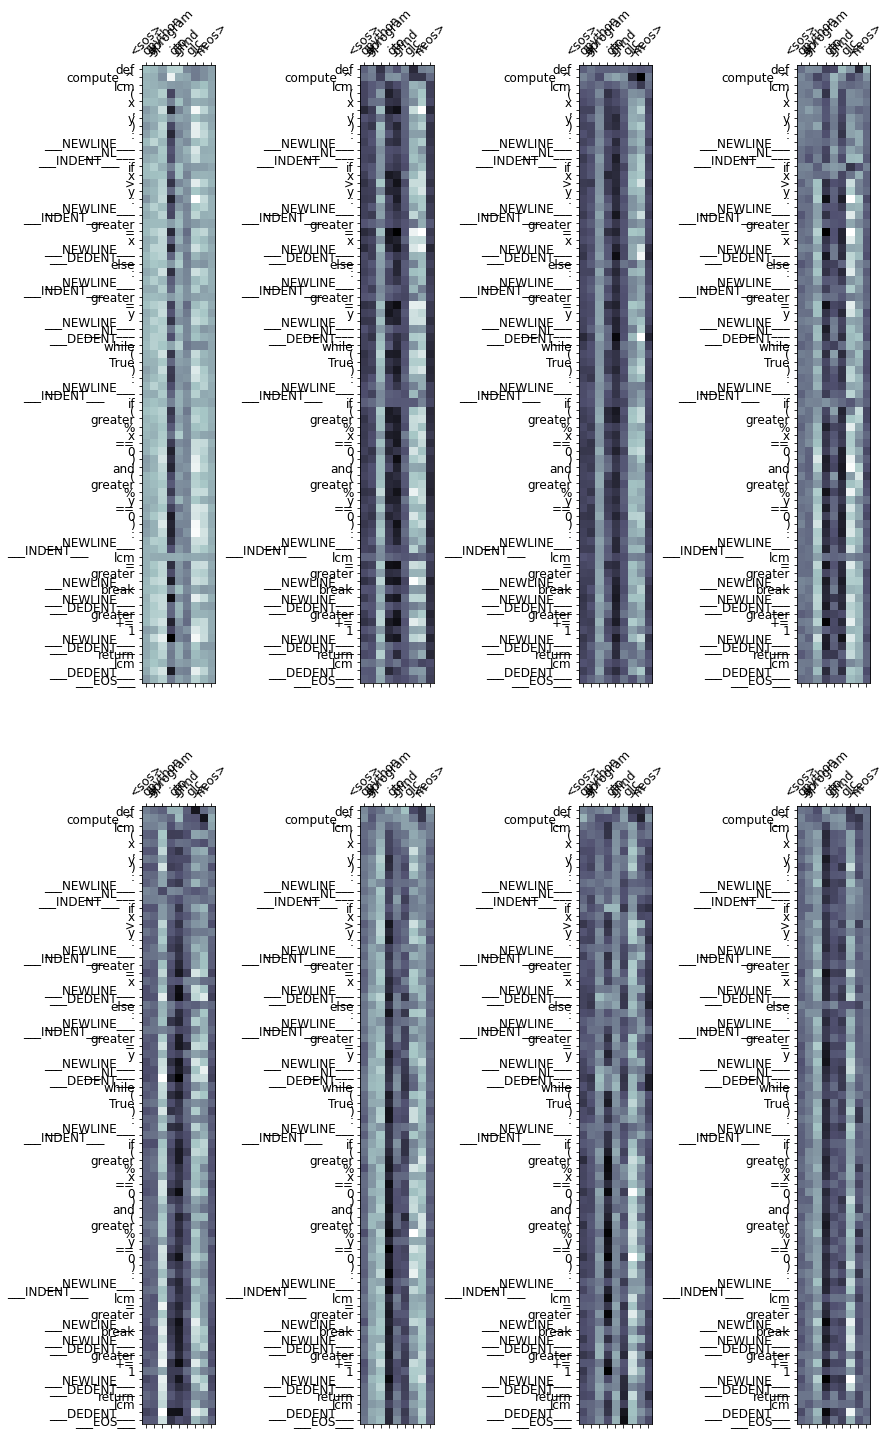

In [ ]:
import matplotlib.ticker as ticker

#display_attention(splitted_text, mycode, attention_val[:,2,:,:].unsqueeze(1), n_heads=1, n_rows=1, n_cols=1)

generate_output(input_text = "# Python Program to Find LCM")

def factorial (n ):
    if n ==1 :
        return n 
    else :
        return n *factorial (n -1 )


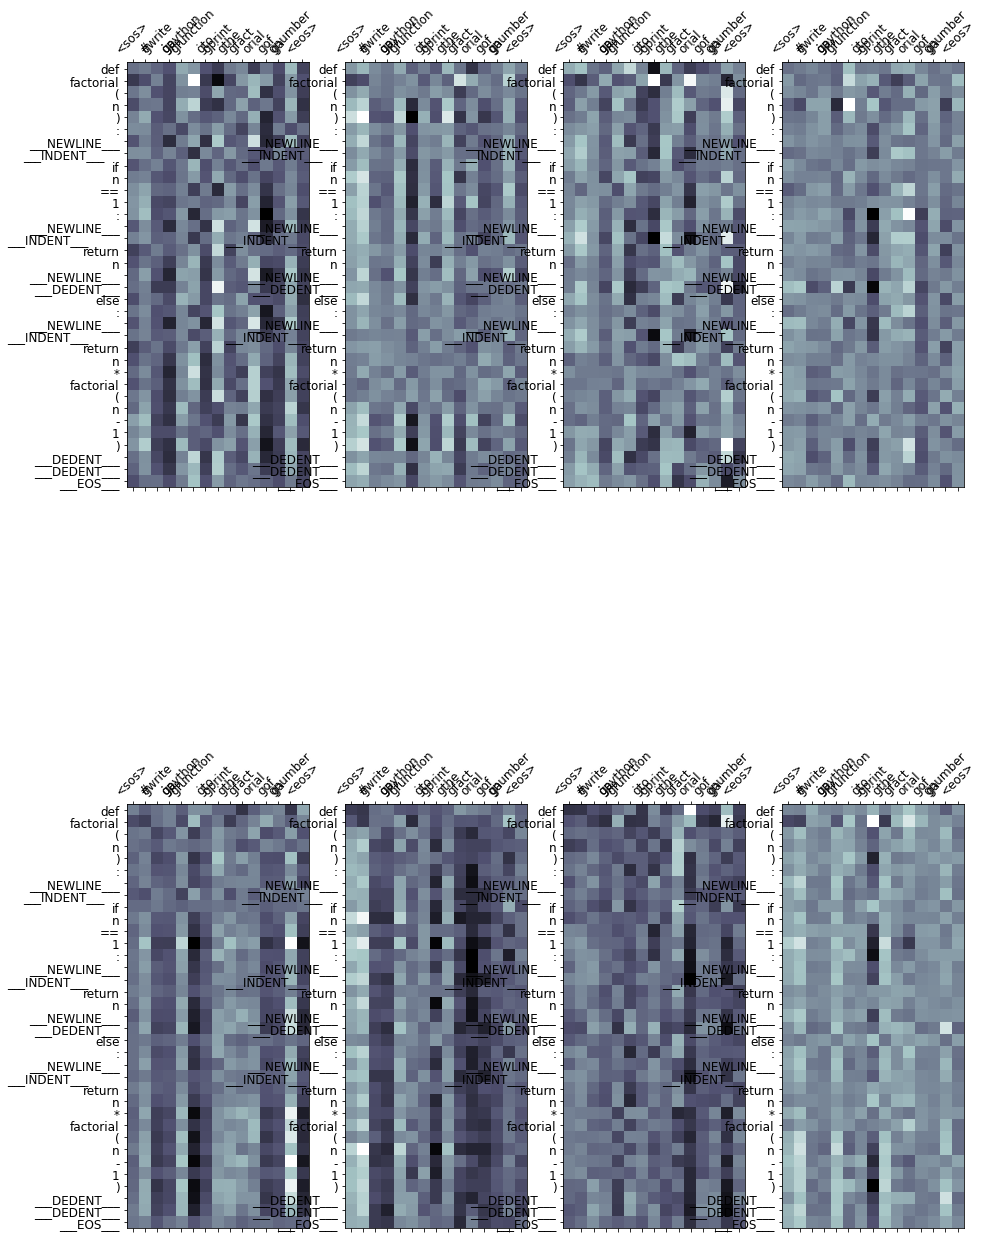

In [ ]:
generate_output(input_text = "# Write a Python function to print the Factorial of a Number")

def recur_fibo (n ):
    if n <=1 :
        return n 
    else :
        return (recur_fibo (n -1 ))+recur_fibo (n -2 ))


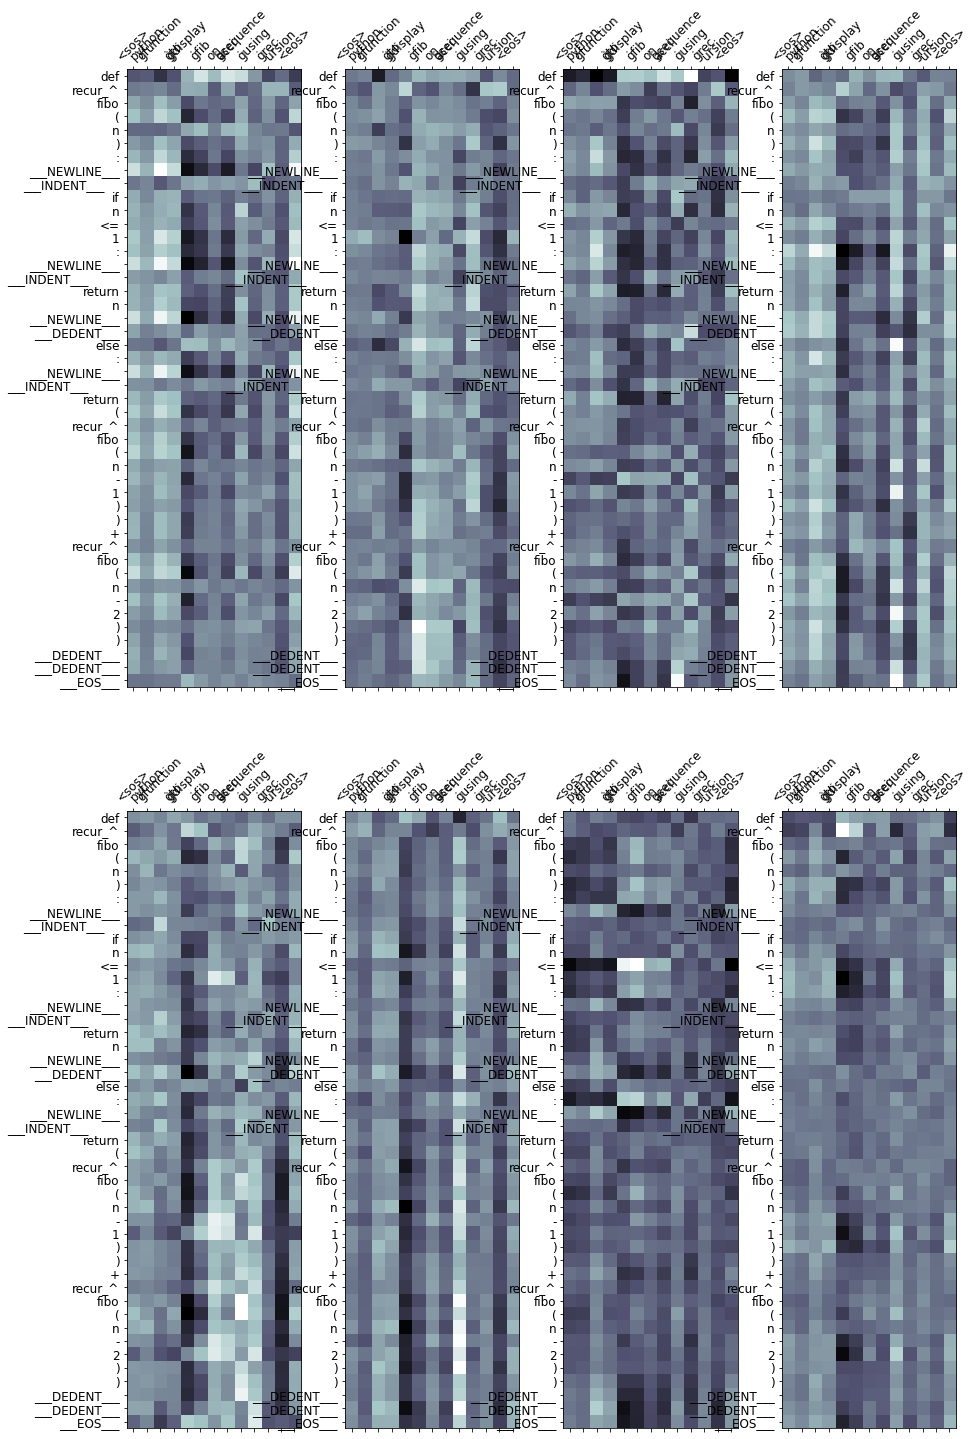

In [ ]:
generate_output(input_text = "Python function to Display Fibonacci Sequence Using Recursion")

def cal_triangle_area (a :float ,b :float ,c :float )->float :
    if a or b or c or c >c :
        s =(a +c )/2 
        area =(s *(s -a )*(s -b )*(s -c )**(s -c )**(s -c )**0.5 
        return None 


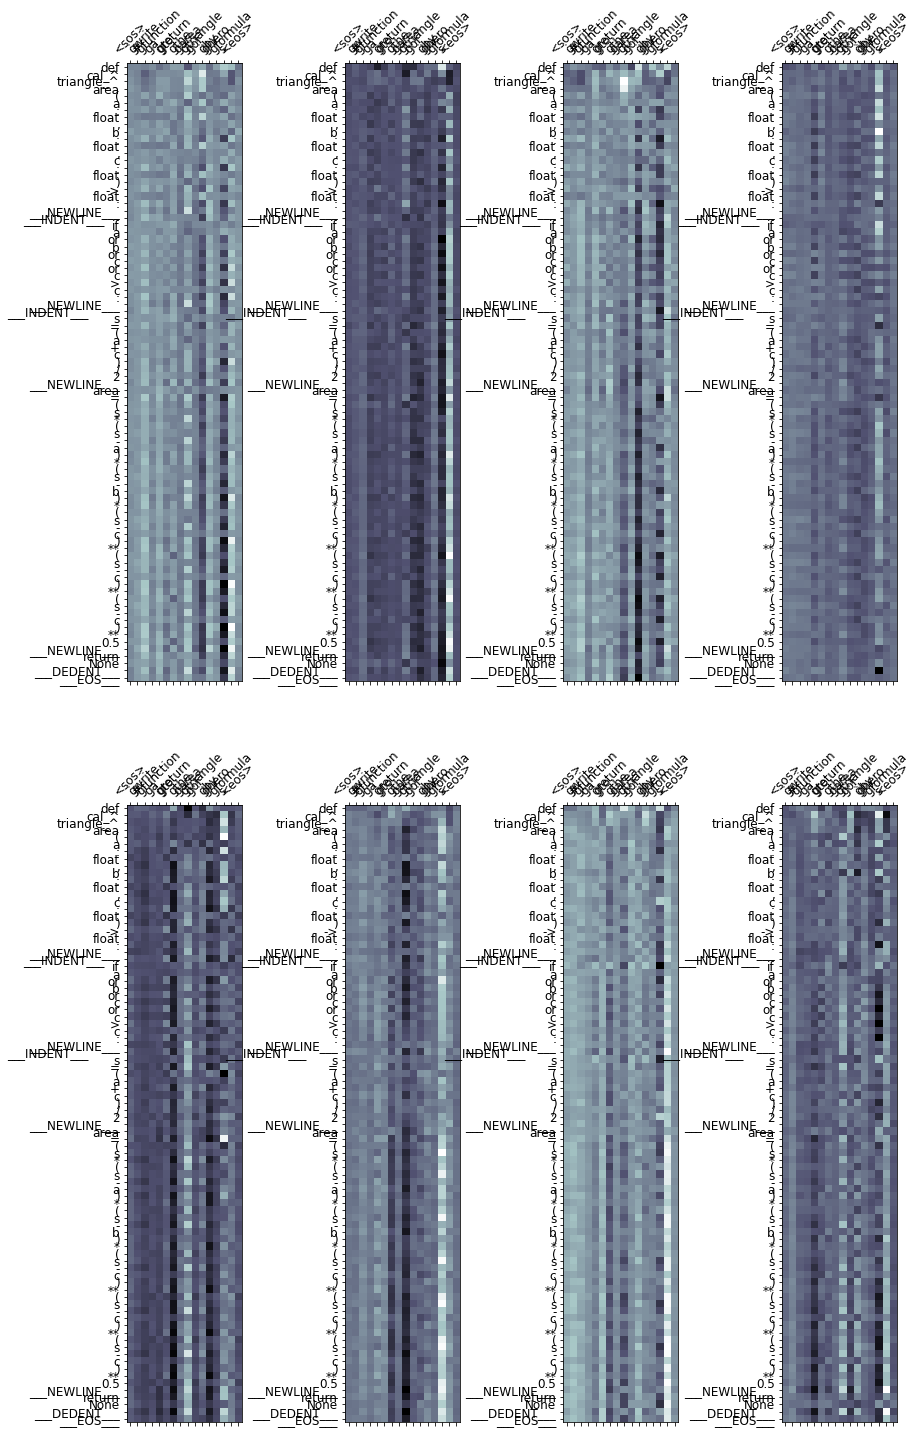

In [ ]:
generate_output(input_text = "# Write a function to return the area of triangle by heros formula")


import re 
def extract_unicode (my_string ):
    regex =re .compile (r'[^\W\d_]+',re .UNICODE )
    return regex .findall (my_string )


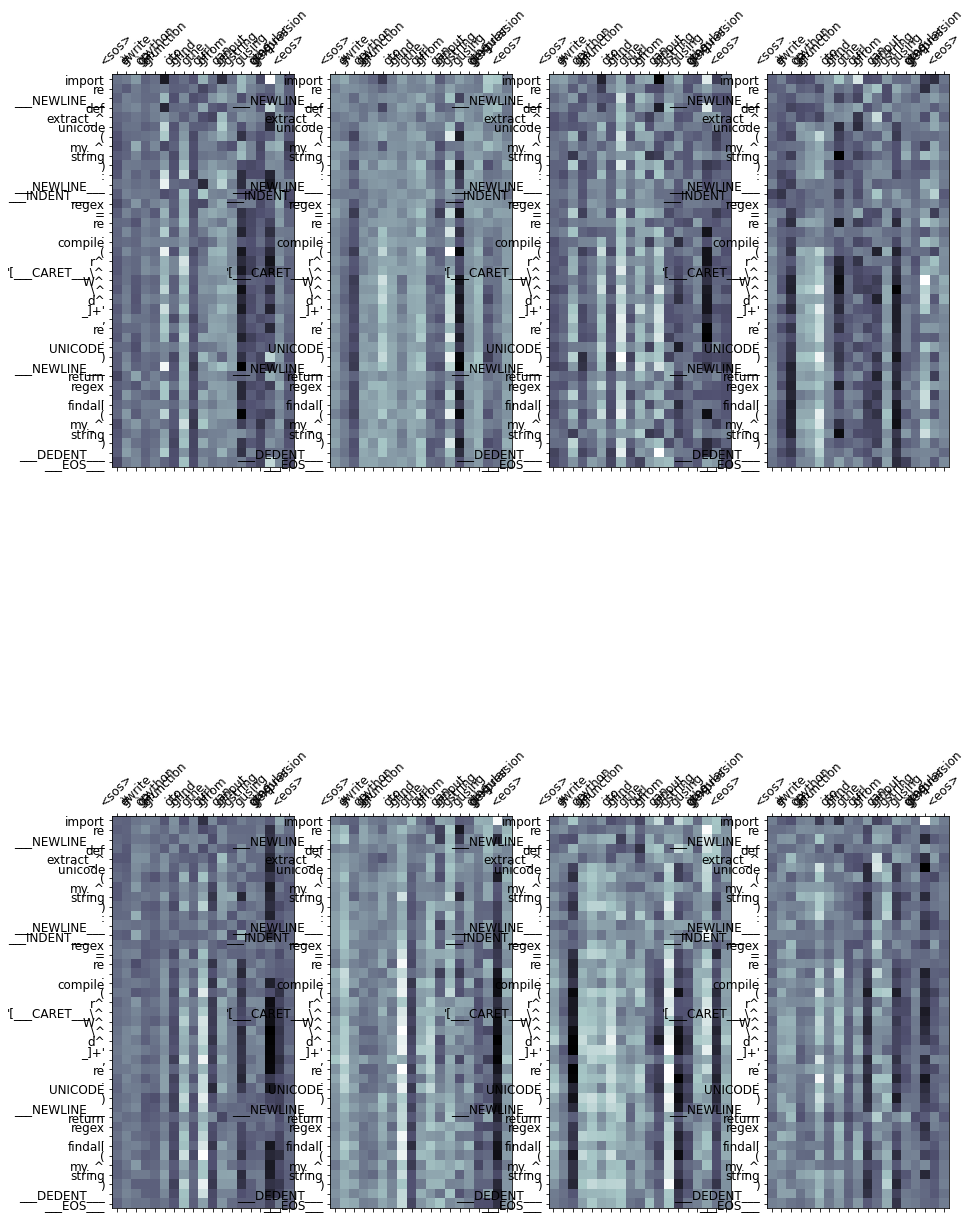

In [ ]:
generate_output(input_text = "# write a python function to find the URL from an input string using the regular expression")


str1 ='TestStringInCamelCase'
no_of_ucase ,no_of_lcase =0 ,0 
for c in str1 :
    if c >='A'and c <='Z':
        no_of_ucase +=1 
    if c >='a'and c <='z':
        no_of_lcase +=1 

print (no_of_lcase )
print (no_of_lcase )


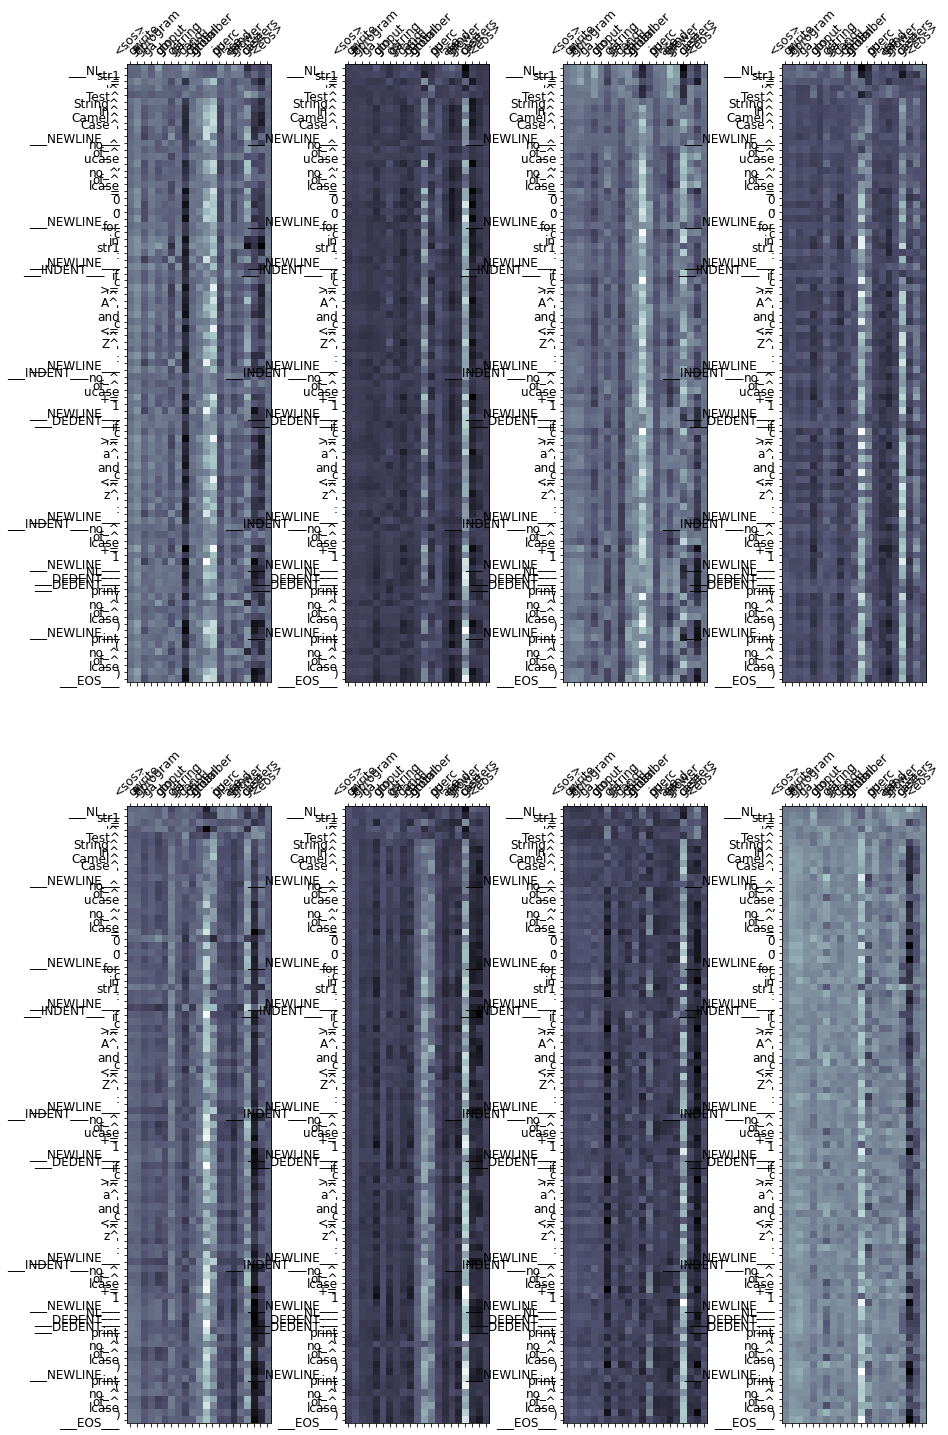

In [ ]:
generate_output(input_text = """# write a program to input a string and find total number uppercase and lowercase letters""")

In [ ]:
generate_output(input_text = """write a python function to print whether the given year is a leap year or not""", disp_attn=False)

def check_leap_year (year :int ):
    if (year %4 )==0 :
        if (year %400 )==0 :
            print ("{0} is a leap year".format (year ))
        else :
            print (year )
    else :
        print ("{0} is a leap year".format (year ))


In [ ]:
generate_output(input_text = """# write a function to find words not in common from two strings""", disp_attn=False)


def UncommonWords (str1 ,str2 ):

    count ={}

    for word in str1 .split ():
        count [word ]=count .get (word ,0 )+1 

    for word in str2 .split ():
        count [word ]=count .get (word ,0 )+1 

    return [word for word in count if count [word ]==1 ]


In [47]:
generate_output(input_text = """Python program to display all the prime numbers within an interval""", disp_attn=False) 


lower =900 
upper =1000 

for num in range (lower ,upper +1 ):
    if num >1 :
        for i in range (2 ,num ):
            if (num %i )==0 :
                break 
        else :
            print (num )


In [49]:
generate_output(input_text = """# Write a python function to remove all the odd numbers from a list and return the remaining list""", disp_attn=False) 


def remove_odd (my_list ):
    result =list (filter (lambda x :(x %2 ==0 ),my_list ))
    return result 


In [50]:
generate_output(input_text = """# Write a function to find acceleration, given u, v and t""", disp_attn=False) 


def acc (u ,v ,t ):
    return (v -u )/t 


In [51]:
generate_output(input_text = """Define a class named American which has a static method called printNationality.""", disp_attn=False) 

class American (object ):
    @staticmethod 
    def printNationality ():
        print "America"
anAmerican =American ()
anAmerican .printNationality ()
American .printNationality ()


In [54]:
generate_output(input_text = """Define a class Person and its two child classes: Male and Female. All classes have a method "getGender" which can print "Male" for Male class and "Female" for Female class.""", disp_attn=False) 

class Person (object ):
    def getGender (self ):
        return "Unknown"

class Male (Person ):
    def getGender (self ):
        return "Male"

class Female (Person ):
    def getGender (self ):
        return "Female"


In [58]:
generate_output(input_text = """Convert Decimal to Binary, Octal and Hexadecimal""", disp_attn=False) 

dec =344 
print ("The decimal value of",dec ,"is:")
print (bin (dec ),"in binary.")
print (oct (dec ),"in octal.")
print (hex (dec ),"in hexadecimal.")


In [71]:
generate_output(input_text = """ write a python function to swap two numbers and print the result """, disp_attn=False) 


num1 =5 
num2 =10 

temp =num1 
num1 =num2 
print ("The value of num1 after swapping: {}".format (num1 ))
print ("The value of num2 after swapping: {}".format (num1 ))


In [85]:
generate_output(input_text = """ write Python3 code to demonstrate working of Extract Tuples with all Numeric Strings Using all() + list comprehension + isdigit() """, disp_attn=False) 

test_list =[("45","86"),("Gfg","1"),("98","10"),("Gfg","Best")]
print ("The original list is : "+str (test_list ))
res =[sub for sub in test_list if all (ele .isdigit ()for ele in sub )]
print ("Filtered Tuples : "+str (res ))


In [94]:
generate_output(input_text = """write Python code to convert string to list""", disp_attn=False) 

def Convert_2 (string ):
    li =list (string .split ("-"))
    return li 

str1 ="Geeks"
print (Convert (str1 ))


In [99]:
generate_output(input_text = """# Write a function that takes two lists as input and returns a zipped list of corresponding elements""", disp_attn=False) 


def zip_list (list1 ,list2 ):
    return list (zip (list1 ,list2 ))


In [101]:
generate_output(input_text = """Function to calculate BMI and prints the comments""", disp_attn=False) 



test_dict ={'gfg':2 ,'is':4 ,'best':5 }

print ("The original dictionary : "+str (test_dict ))
s ={'cal_.txt':1 ,'r':4 ,'cal_':7 }
res =dict (zip (*values ,values ))
print ("The dictionary : "+str (res ))


In [110]:
generate_output(input_text = """ write a python function to return unique elements of a list""", disp_attn=False) 

def unique_list (l ):
    x1 =[]
    for a in l :
        if a not in x1 :
            x1 .append (a )
    return x1 

print (unique_list ([1 ,2 ,3 ,3 ,3 ,4 ,5 ]))


In [112]:
generate_output(input_text = """ write a python program to print todays date""", disp_attn=False) 

print (datetime .today ())


In [119]:
generate_output(input_text = """ Write a function to calculate the compound interest for principal p, rate r and time in years y """, disp_attn=False) 

def get_ci (p :float ,r :float ,t :float ,n :float )->float :
    return round (p *(((((((1 +(r /(n *100 ))))))**(n *t ))-p ,2 )


In [121]:
generate_output(input_text = """# write a python generator function for generating Fibonacci Numbers""", disp_attn=False) 

def fib (limit ):

    a ,b =0 ,1 

    while a <limit :
        yield a 
        a ,b =b ,a +b 


In [127]:
generate_output(input_text = """write a program to remove all the characters except numbers and alphabets """, disp_attn=False) 


from functools import reduce 

ini_string ="123abcjw:, .@! eiw"

print ("initial string : ",ini_string )

result =re .sub ('[\W_]+','',ini_string )

print ("final string",result )


In [129]:
generate_output(input_text="""# Define a custom exception class which takes a string message as attribute.""",disp_attn=False)

class MyError (Exception ):
    def __init__ (self ,msg ):
        self .msg =msg 
error =MyError ("something wrong")


### Bloopers

In [132]:
generate_output(input_text="""# write a python function to convert a given string into a list of words.""",disp_attn=False)


def get_sha256 (text ):
    import hashlib 
    return hashlib .sha256 (text ).encode ().hexdigest ()


In [134]:
def get_sha256 (text ):
    import hashlib 
    return hashlib .sha256 (text ).encode ().hexdigest ()

In [136]:
generate_output(input_text="""# Write a Python function to print whether the given Date is valid or not""",disp_attn=False)

def date_validator (d ,m ,y ):
    import datetime 
    try :
        s =datetime .date (y ,m ,d )
        print ("Date is valid.")
    except ValueError :
        print ("Date is invalid.")


In [139]:
generate_output(input_text="""write a Python function to find surface area of Pentagonal Prism """,disp_attn=False)


def findArea (a ,b ):
    Area =3.142 *a *b *h 
    return 5 *h 

a =5 
b =5 
print ("Area of =",h (a ,b ))
